# Reading Data from Multiple S3 Buckets using Bacalhau


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/workload-onboarding/Reading-from-Multiple-S3-buckets/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=workload-onboarding/Reading-from-Multiple-S3-buckets/index.ipynb)
[![stars - badge-generator](https://img.shields.io/github/stars/bacalhau-project/bacalhau?style=social)](https://github.com/bacalhau-project/bacalhau)

## Introduction

Bacalhau, a powerful and versatile data processing platform, has recently integrated Amazon Web Services (AWS) S3, allowing users to seamlessly access and process data stored in S3 buckets within their Bacalhau jobs. This integration not only simplifies data input, output, and processing operations but also streamlines the overall workflow by enabling users to store and manage their data effectively in S3 buckets. With bacalhau you can process several Large s3 buckets in parallel . In this example, we will walk you through the process of reading data from multiple S3 buckets, converting TIFF images to JPEG format.

### Advantages of Converting TIFF to JPEG

There are several advantages to converting images from TIFF to JPEG format:

1. **Reduced File Size**: JPEG images use lossy compression, which significantly reduces file size compared to lossless formats like TIFF. Smaller file sizes lead to faster upload and download times, as well as reduced storage requirements.
2. **Efficient Processing**: With smaller file sizes, image processing tasks tend to be more efficient and require less computational resources when working with JPEG images compared to TIFF images.
3. **Training Machine Learning Models**: Smaller file sizes and reduced computational requirements make JPEG images more suitable for training machine learning models, particularly when dealing with large datasets, as they can help speed up the training process and reduce the need for extensive computational resources.


## Running the job on Bacalhau

We will use the S3 mount feature to mount several bucket objects from public s3 buckets located in different regions.

Firstly we will demonstrate how to run the job with just one bucket and then run the same job on 5 buckets located in different regions.

### Prerequisite

To get started, you need to install the Bacalhau client, see more information [here](https://docs.bacalhau.org/getting-started/installation)


### Running the job on a multiple buckets with multiple objects

In [ ]:
!curl -sL https://get.bacalhau.org/install.sh | bash

In [ ]:
%%bash --out job_id
bacalhau docker run \
--wait \
--id-only \
--timeout 3600 \
--wait-timeout-secs 3600 \
-i src=s3://bdc-sentinel-2/s2-16d/v1/075/086/2018/02/18/*,dst=/bdc-sentinel-2/,opt=region=us-west-2  \
-i src=s3://sentinel-cogs/sentinel-s2-l2a-cogs/28/M/CV/2022/6/S2B_28MCV_20220620_0_L2A/*,dst=/sentinel-cogs/,opt=region=us-west-2 \
jsacex/gdal-s3

**`-i src=s3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/10/S/DH/2017/S1A_20170125_10SDH_ASC/Gamma0_VH.tif,dst=/sentinel-s1-rtc-indigo/,opt=region=us-west-2`** 

Breakdown of the flag:

`-i src=s3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/10/S/DH/2017/S1A_20170125_10SDH_ASC/Gamma0_VH.tif`: 

Specifying the bucket source along with the keys in this case it's `s3://bdc-sentinel-2/s2-16d/v1/075/086/2018/02/18/*` but if you want to specify the entire objects located in the path you can simply add `*` to the end of the path `s3://bdc-sentinel-2/s2-16d/v1/075/086/2018/02/18/*`

`dst=/bdc-sentinel-2/`: the destination to which to mount the s3 bucket object

`opt=region=us-west-2`: Specifying the region in which the bucket is located


We find all the .tif files and then convert and save them to /outputs/


The job has been submitted and Bacalhau has printed out the related job id. We store that in an environment variable so that we can reuse it later on.

In [ ]:
%env JOB_ID={job_id}

## Checking the State of your Jobs

- **Job status**: You can check the status of the job using `bacalhau list`. 

In [ ]:
%%bash
bacalhau list --id-filter=${JOB_ID} --no-style

When it says `Published` or `Completed`, that means the job is done, and we can get the results.

- **Job information**: You can find out more information about your job by using `bacalhau describe`.

In [ ]:
%%bash
bacalhau describe ${JOB_ID}

- **Job download**: You can download your job results directly by using `bacalhau get`. Alternatively, you can choose to create a directory to store your results. In the command below, we created a directory and downloaded our job output to be stored in that directory.

In [ ]:
%%bash
rm -rf results && mkdir results # Temporary directory to store the results
bacalhau get ${JOB_ID} --output-dir results # Download the results

After the download has finished you should see the following contents in results directory.

## Viewing your Job Output

To view the file, run the following command:

### Display the image

To view the images, we will use **glob** to return all file paths that match a specific pattern. 

results/outputs/S2-16D_V1_075086_20180218_B04_TCI.jpg


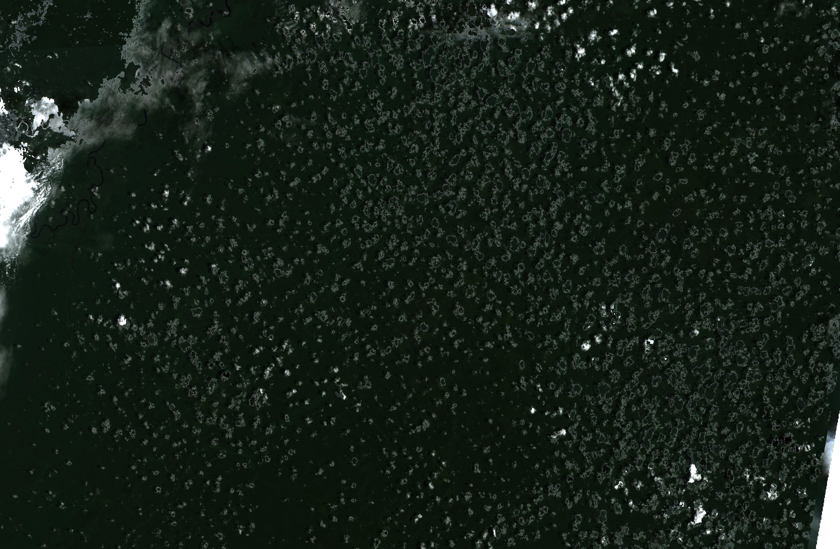

results/outputs/B04_TCI.jpg


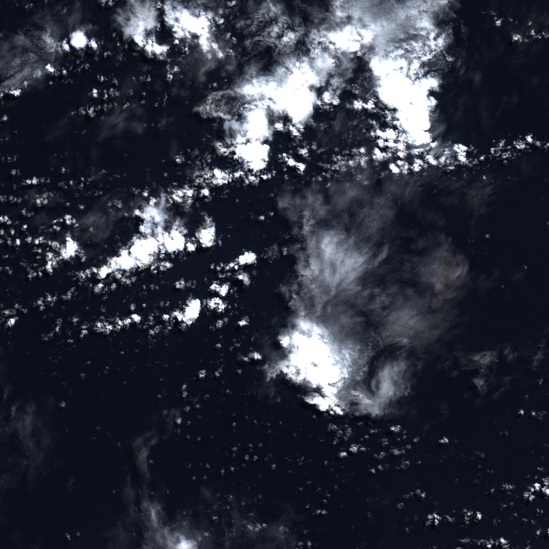

In [ ]:
import glob
from PIL import Image as PILImage
from IPython.display import display

# Define the factor by which to reduce the image size
factor = 10

for imageName in glob.glob('results/outputs/*.jpg'):
    with PILImage.open(imageName) as img:
        print(imageName)
        # Crop the image to the first 50% of its width
        width, height = img.size
        left = 0
        right = width // 2
        top = 0
        bottom = height // 2
        img = img.crop((left, top, right, bottom))

        # Calculate the new dimensions based on the reduction factor
        new_width = img.width // factor
        new_height = img.height // factor
        
        # Resize the image to the new dimensions
        img = img.resize((new_width, new_height))
        
        # Display the image
        display(img)
